## Welfare Ranges Calculations

### Import simulated scores


In [1]:
import os
import pickle
import copy 
import collections
import warnings
import csv
import platform
import test_simulations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from logging import warning
from operator import concat
from struct import unpack
from IPython.display import display

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (18.5 * 0.65, 10.5 * 0.65)

SPECIES = ['pigs', 'chickens', 'carp', 'salmon', 'octopuses', 'shrimp', 'crabs', 'crayfish', 'bees', 'bsf', 'silkworms']

SCENARIO_RANGES = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99]

params = pickle.load(open(os.path.join('input_data', "Welfare Range Parameters.p"), 'rb'))
NUM_SCENARIOS = params['N_SCENARIOS']
HC_WEIGHT = params['HC_WEIGHT']
WEIGHT_NOS = params['WEIGHT_NOS']

sent_params = pickle.load(open(os.path.join('input_data', 'Sentience Parameters.p'), 'rb'))
SENT_HC_WEIGHT = sent_params['HC_WEIGHT']

# import simulated scores
pig_scores = pickle.load(open('{}_simulated_scores.p'.format(os.path.join('output_data', "wr_pigs")), 'rb'))
chicken_scores = pickle.load(open('{}_simulated_scores.p'.format(os.path.join('output_data', "wr_chickens")), 'rb'))
carp_scores = pickle.load(open('{}_simulated_scores.p'.format(os.path.join('output_data', "wr_carp")), 'rb'))
salmon_scores = pickle.load(open('{}_simulated_scores.p'.format(os.path.join('output_data', "wr_salmon")), 'rb'))
octopus_scores = pickle.load(open('{}_simulated_scores.p'.format(os.path.join('output_data', "wr_octopuses")), 'rb'))
shrimp_scores = pickle.load(open('{}_simulated_scores.p'.format(os.path.join('output_data', "wr_shrimp")), 'rb'))
crab_scores = pickle.load(open('{}_simulated_scores.p'.format(os.path.join('output_data', "wr_crabs")), 'rb'))
crayfish_scores = pickle.load(open('{}_simulated_scores.p'.format(os.path.join('output_data', "wr_crayfish")), 'rb'))
bee_scores = pickle.load(open('{}_simulated_scores.p'.format(os.path.join('output_data', "wr_bees")), 'rb'))
bsf_scores = pickle.load(open('{}_simulated_scores.p'.format(os.path.join('output_data', "wr_bsf")), 'rb'))
silkworm_scores = pickle.load(open('{}_simulated_scores.p'.format(os.path.join('output_data', "wr_silkworms")), 'rb'))

unknown_probabilities = pickle.load(open(os.path.join('input_data', "Welfare Range Unknown Probabilities.p"), 'rb'))

overlap_csv = os.path.join('input_data', 'Proxy Overlap.csv')
overlap_dict = {}
with open(overlap_csv) as f:
    reader = csv.reader(f, delimiter=',')
    for idx, rec in enumerate(reader):
        if idx == 0:
            continue
        else:
            sent_proxy = rec[0].strip()
            in_both = rec[1].strip()
            corr_proxy = rec[2].strip()
            if in_both == "y":
                if corr_proxy not in overlap_dict:
                    overlap_dict[corr_proxy] = []
                overlap_dict[corr_proxy].append(sent_proxy)

data = {'pigs': {'Scores': pig_scores, 'FFF': 75, 'Unknown Prob': unknown_probabilities['pigs']}, 
        'chickens': {'Scores': chicken_scores, 'FFF': 50, 'Unknown Prob': unknown_probabilities['chickens']}, 
        'carp': {'Scores': carp_scores, 'FFF': 72, 'Unknown Prob': unknown_probabilities['carp']}, 
        'salmon': {'Scores': salmon_scores, 'FFF': 72, 'Unknown Prob': unknown_probabilities['salmon']},
        'octopuses': {'Scores': octopus_scores, 'FFF': 45, 'Unknown Prob': unknown_probabilities['octopuses']}, 
        'shrimp': {'Scores': shrimp_scores, 'FFF': 80, 'Unknown Prob': unknown_probabilities['shrimp']}, 
        'crabs': {'Scores': crab_scores, 'FFF': 14, 'Unknown Prob': unknown_probabilities['crabs']}, 
        'crayfish': {'Scores': crayfish_scores, 'FFF': 55, 'Unknown Prob': unknown_probabilities['crayfish']},
        'bees': {'Scores': bee_scores, 'FFF': 110, 'Unknown Prob': unknown_probabilities['bees']}, 
        'bsf': {'Scores': bsf_scores, 'FFF': None, 'Unknown Prob': unknown_probabilities['bsf']}, 
        'silkworms': {'Scores': silkworm_scores, 'FFF': None, 'Unknown Prob': unknown_probabilities['silkworms']}}

print(test_simulations.test_wr_scores(data, overlap_dict, HC_WEIGHT, SENT_HC_WEIGHT, SPECIES))

def run_cmd(cmd):
    print(cmd)
    os.system(cmd)

if platform.system() == 'Darwin' or platform.system() == 'Linux':
    run_cmd('rm -rf welfare_range_estimates')
    run_cmd('mkdir welfare_range_estimates')
elif platform.system() == 'Windows':
    run_cmd('rmdir /Q /S welfare_range_estimates')
    run_cmd('mkdir welfare_range_estimates')
else:
    raise ValueError('Platform `{}` not supported'.format(platform.system()))


All proxies with zero/one probabilities have scores equal to their expected values
Number proxies whose proportion was outside 95% CI: 14
Proportion of total proxies whose mean score was outside of the 95% CI: 0.059
Probability of getting > 14/239 proxies outside of their 95% CI: 0.219
Pass Test:
True
rm -rf welfare_range_estimates
mkdir welfare_range_estimates


## Import Proxies Lists for Each Model


In [2]:
# import proxies lists for each model
model_proxies_df = pd.read_csv(os.path.join('input_data', 'WR Model Proxies.csv'))
# qualitative proxies
qual_proxies_list = model_proxies_df['qualitative'].dropna().values.tolist()
qual_proxies = set()
for proxy in qual_proxies_list:
    if proxy.lower() != "none":
        qual_proxies.add(proxy)

# cubic proxies
cubic_proxies_list = model_proxies_df['cubic'].dropna().values.tolist()
cubic_proxies = set()
for proxy in cubic_proxies_list:
    if proxy.lower() != "none":
        cubic_proxies.add(proxy)

# high-confidence proxies
hc_csv = os.path.join('input_data', 'WR High-Confidence Proxies.csv')
hc_proxies = set()
with open(hc_csv, newline='') as f:
    reader = csv.reader(f)
    hc_proxies_lists = list(reader)
for i, item in enumerate(hc_proxies_lists):
    if i == 0:
        continue
    else:
        hc_proxies.add(item[0])

# qualitative minus social (QMS) proxies
qms_proxies_list = model_proxies_df['qualitative minus social'].dropna().values.tolist()
qms_proxies = set()
for proxy in qms_proxies_list:
    if proxy.lower() != "none":
        qms_proxies.add(proxy)

# pleasure-and-pain-centric (PPC) proxies
ppc_proxies_list = model_proxies_df['pleasure-and-pain-centric'].dropna().values.tolist()
ppc_proxies = set()
for proxy in ppc_proxies_list:
    if proxy.lower() != "none":
        ppc_proxies.add(proxy)

# higher/lower cognitive pleasures (HLP_COG) proxies
hlp_cog_proxies_list = model_proxies_df['higher/lower pleasures - cognitive'].dropna().values.tolist()
hlp_cog_proxies = set()
for proxy in hlp_cog_proxies_list:
    if proxy.lower() != "none":
        hlp_cog_proxies.add(proxy)

# higher/lower hedonic pleasures (HLP_HED) proxies
hlp_hed_proxies_list = model_proxies_df['higher/lower pleasures - hedonic'].dropna().values.tolist()
hlp_hed_proxies = set()
for proxy in hlp_hed_proxies_list:
    if proxy.lower() != "none":
        hlp_hed_proxies.add(proxy)

# undiluted experience cognitive pleasures (UE_COG) proxies
ue_cog_proxies_list = model_proxies_df['undiluted experience - cognitive'].dropna().values.tolist()
ue_cog_proxies = set()
for proxy in ue_cog_proxies_list:
    if proxy.lower() != "none":
        ue_cog_proxies.add(proxy)

# higher/lower hedonic pleasures (HLP_HED) proxies
ue_hed_proxies_list = model_proxies_df['undiluted experience - hedonic'].dropna().values.tolist()
ue_hed_proxies = set()
for proxy in ue_hed_proxies_list:
    if proxy.lower() != "none":
        ue_hed_proxies.add(proxy)

## General Code for Generating Welfare Range Distributions (Simple Scoring)

In [3]:

def filter_proxies(species_scores, model_proxies):
    filtered_scores = {}
    for proxy, scores_list in species_scores.items():
        if proxy in model_proxies:
            filtered_scores[proxy] = scores_list
    return filtered_scores

def get_human_sum(model_name, model_proxies, hc_proxies):
    human_sum = 0

    for proxy in model_proxies:
        if model_name in {"High-Confidence (Simple Scoring)", "High-Confidence (Cubic)"}:
            human_sum += 1
        else:
            if proxy in hc_proxies:
                human_sum += HC_WEIGHT
            else:
                human_sum += 1
    return human_sum

def one_sim_welfare_range(model_name, f, filtered_scores, sim_idx, fff, human_sum):
    welfare_sum = 0
    for scores_list in filtered_scores.values():
        score_i = scores_list[sim_idx]
        if model_name in {"High-Confidence (Simple Scoring)", "High-Confidence (Cubic)"}:
            score_i = score_i/HC_WEIGHT
        welfare_sum += score_i

    adjusted_species_sum = f(welfare_sum)
    adjusted_human_sum = f(human_sum)
    if fff is not None:
        ffr = fff/60
        welfare_range = max(0.28*(adjusted_species_sum/adjusted_human_sum)*ffr + 0.72*(adjusted_species_sum/adjusted_human_sum), 0)
    else: 
        welfare_range = max(adjusted_species_sum/adjusted_human_sum, 0)
    return welfare_range

def one_species_welfare_ranges(model_name, f, species_scores, model_proxies, hc_proxies, fff):
    filtered_scores = filter_proxies(species_scores, model_proxies)
    human_sum = get_human_sum(model_name, model_proxies, hc_proxies)
    
    welfare_range_list = []
    for i in range(NUM_SCENARIOS):
        welfare_range_i = one_sim_welfare_range(model_name, f, filtered_scores, i, fff, human_sum)
        welfare_range_list.append(welfare_range_i)
    
    return welfare_range_list

def plot_range_distribution(species, welfare_range_list):
    welfare_range_array = np.array(welfare_range_list)
    plt.hist(welfare_range_array, bins=20, density=True)
    plt.axvline(x=np.percentile(welfare_range_array, SCENARIO_RANGES)[1], color='k', linestyle='dashed', linewidth=1)
    plt.axvline(x=np.percentile(welfare_range_array, SCENARIO_RANGES)[11], color='k', linestyle='dashed', linewidth=1)
    plt.title("Distribution of {} Welfare Ranges".format(species))
    plt.show()
    print('-')

def one_species_summary_stats(species, welfare_range_list, to_print=False):
    welfare_range_array = np.array(welfare_range_list)
    percentiles = np.percentile(welfare_range_array, SCENARIO_RANGES)
    fifth_percentile = percentiles[1]
    ninty_fifth_percentile = percentiles[11]
    median = percentiles[6]
    stats_tuple = (fifth_percentile, median, ninty_fifth_percentile)
    if to_print:
        print("5th-percentile welfare range: {}".format(fifth_percentile))
        print("50th-percentile welfare range: {}".format(median))
        print("95th-percentile welfare range: {}".format(ninty_fifth_percentile))
    return stats_tuple

def all_species_welfare_ranges_simple_scoring(f, model_name, data, model_proxies, hc_proxies, SPECIES, to_plot=False):
    fifth_percentiles = []
    medians = []
    ninty_fifth_percentiles = []

    for species in SPECIES: 
        species_scores = data[species]["Scores"]
        fff_species = data[species]["FFF"]
        species_welfare_range_lst = one_species_welfare_ranges(model_name, f, species_scores, model_proxies, hc_proxies, fff_species)
        pickle.dump(np.array(species_welfare_range_lst), open(os.path.join('welfare_range_estimates','{}_wr_{}_model.p'.format(species, model_name)), 'wb'))
        if to_plot:
            plot_range_distribution(species, species_welfare_range_lst)
        species_stats = one_species_summary_stats(species, species_welfare_range_lst)
        fifth_percentiles.append(round(species_stats[0],3))
        medians.append(round(species_stats[1],3))
        ninty_fifth_percentiles.append(round(species_stats[2],3))

    cols = ["5th-pct", "50th-pct", "95th-pct"]
    welfare_range_stats_df = pd.DataFrame(list(zip(fifth_percentiles, medians, ninty_fifth_percentiles)), \
        columns=cols, index=SPECIES)
    welfare_range_stats_df = welfare_range_stats_df.sort_values("50th-pct", ascending=False)
    path = os.path.join('welfare_range_estimates', "WR {} Summary Statistics.csv".format(model_name))
    wfr_stats_csv = welfare_range_stats_df.to_csv(path, index_label="Species")
    print(model_name.upper())
    print(welfare_range_stats_df)
    return welfare_range_stats_df

    

## Parameters for these Simulations

In [4]:
print("For all the models below, the assumptions are that...")

if WEIGHT_NOS == "Yes":
    print("'Likely no's and 'Lean no's are given probabilities between [0,0.25) and [0.25,0.5) of being true.")
else:
    print("'Likely no's and 'Lean no's are given no probability of being true.")

print("Proxies we're higly confident matter for welfare capacities are given", HC_WEIGHT, "x the weight of other proxies.")

def unknown_probs_df():
    unknown_probs = []
    for species in SPECIES:
        unknown_prob = data[species]["Unknown Prob"]
        unknown_probs.append(unknown_prob)
    cols = ['Unknown Prob.']
    unknowns_df = pd.DataFrame(unknown_probs, columns=cols, index=SPECIES)
    print(unknowns_df) 

unknown_probs_df()


For all the models below, the assumptions are that...
'Likely no's and 'Lean no's are given probabilities between [0,0.25) and [0.25,0.5) of being true.
Proxies we're higly confident matter for welfare capacities are given 5 x the weight of other proxies.
           Unknown Prob.
pigs                   0
chickens               0
carp                   0
salmon                 0
octopuses              0
shrimp                 0
crabs                  0
crayfish               0
bees                   0
bsf                    0
silkworms              0


## Qualitative Model

In [5]:
def qual_f(welfare_sum):
    adjusted_welfare_sum = welfare_sum
    return adjusted_welfare_sum

qual_wr_stats = all_species_welfare_ranges_simple_scoring(qual_f, "Qualitative", data, qual_proxies, hc_proxies, SPECIES, to_plot=False)


QUALITATIVE
           5th-pct  50th-pct  95th-pct
pigs         0.571     0.665     0.747
chickens     0.408     0.481     0.548
bees         0.358     0.444     0.522
carp         0.319     0.400     0.476
octopuses    0.312     0.381     0.448
salmon       0.238     0.295     0.345
crayfish     0.172     0.231     0.286
shrimp       0.133     0.192     0.246
crabs        0.110     0.152     0.191
bsf          0.072     0.117     0.158
silkworms    0.068     0.113     0.151


## High-Confidence (Simple Scoring)

In [6]:
def ss_hc_f(welfare_sum):
    adjusted_welfare_sum = welfare_sum
    return adjusted_welfare_sum

ss_hc_wr_stats = all_species_welfare_ranges_simple_scoring(ss_hc_f, "High-Confidence (Simple Scoring)", data, hc_proxies, hc_proxies, SPECIES, to_plot=False)

HIGH-CONFIDENCE (SIMPLE SCORING)
           5th-pct  50th-pct  95th-pct
pigs         0.581     0.703     0.825
chickens     0.409     0.490     0.572
bees         0.352     0.458     0.564
carp         0.332     0.422     0.513
octopuses    0.319     0.399     0.478
salmon       0.241     0.302     0.362
crayfish     0.167     0.251     0.307
shrimp       0.125     0.187     0.250
crabs        0.112     0.157     0.202
bsf          0.057     0.114     0.171
silkworms    0.057     0.114     0.171


## Cubic Model

In [7]:
def cubic_f(welfare_sum):
    adjusted_welfare_sum = welfare_sum**3
    return adjusted_welfare_sum

cubic_wr_stats = all_species_welfare_ranges_simple_scoring(cubic_f, "Cubic", data, cubic_proxies, hc_proxies, SPECIES, to_plot=False)

CUBIC
           5th-pct  50th-pct  95th-pct
pigs         0.163     0.256     0.366
chickens     0.076     0.124     0.182
octopuses    0.036     0.065     0.104
bees         0.031     0.059     0.095
carp         0.029     0.058     0.095
salmon       0.012     0.024     0.037
crayfish     0.006     0.013     0.024
shrimp       0.002     0.006     0.012
crabs        0.002     0.006     0.011
bsf          0.000     0.002     0.004
silkworms    0.000     0.001     0.004


## High-Confidence Proxies (Cubic Model)

In [8]:
def cubic_hc_f(welfare_sum):
    adjusted_welfare_sum = welfare_sum**3
    return adjusted_welfare_sum

hc_cubic_wr_stats = all_species_welfare_ranges_simple_scoring(cubic_hc_f, "High-Confidence (Cubic)", data, \
    hc_proxies, hc_proxies, SPECIES, to_plot=False)

HIGH-CONFIDENCE (CUBIC)
           5th-pct  50th-pct  95th-pct
pigs         0.171     0.304     0.491
chickens     0.075     0.130     0.206
octopuses    0.037     0.073     0.127
carp         0.033     0.068     0.121
bees         0.029     0.063     0.118
salmon       0.013     0.025     0.043
crayfish     0.005     0.017     0.030
shrimp       0.002     0.006     0.013
crabs        0.002     0.006     0.013
bsf          0.000     0.001     0.005
silkworms    0.000     0.001     0.005


## Qualitative Minus Social Model

In [9]:
def qms_f(welfare_sum):
    adjusted_welfare_sum = welfare_sum
    return adjusted_welfare_sum

qms_wr_stats = all_species_welfare_ranges_simple_scoring(qms_f, "Qualitative Minus Social", data, \
    qms_proxies, hc_proxies, SPECIES, to_plot=False)

QUALITATIVE MINUS SOCIAL
           5th-pct  50th-pct  95th-pct
pigs         0.568     0.673     0.769
chickens     0.403     0.484     0.553
bees         0.362     0.458     0.544
octopuses    0.336     0.412     0.484
carp         0.302     0.392     0.474
salmon       0.234     0.305     0.357
crayfish     0.166     0.232     0.287
shrimp       0.147     0.209     0.265
crabs        0.117     0.166     0.211
bsf          0.072     0.124     0.170
silkworms    0.067     0.121     0.168


## Pleasure-and-pain-centric Model

In [10]:
def ppc_f(welfare_sum):
    adjusted_welfare_sum = welfare_sum
    return adjusted_welfare_sum

ppc_wr_stats = all_species_welfare_ranges_simple_scoring(ppc_f, "Pleasure-and-pain-centric", data, ppc_proxies, \
    hc_proxies, SPECIES, to_plot=False)

PLEASURE-AND-PAIN-CENTRIC
           5th-pct  50th-pct  95th-pct
pigs         0.529     0.662     0.772
carp         0.381     0.533     0.653
octopuses    0.403     0.527     0.623
chickens     0.354     0.462     0.560
salmon       0.305     0.425     0.523
bees         0.292     0.420     0.559
crayfish     0.222     0.322     0.423
shrimp       0.180     0.304     0.406
crabs        0.146     0.251     0.308
silkworms    0.062     0.155     0.216
bsf          0.052     0.113     0.165


## General Code for Non-Simple Scoring Welfare Ranges


In [11]:
def get_human_sum_2(model_proxies, hc_proxies):
    human_sum = 0

    for proxy in model_proxies:
        if proxy in hc_proxies:
            human_sum += HC_WEIGHT
        else:
            human_sum += 1

    return human_sum

def one_sim_relative_score(filtered_scores, sim_idx, human_sum):
    welfare_sum = 0
    for scores_list in filtered_scores.values():
        score_i = scores_list[sim_idx]
        welfare_sum += score_i

    relative_score = welfare_sum/human_sum
    return relative_score

def one_sim_welfare_range_2(f, cognitive_scores, hedonic_scores, human_sum_cog, human_sum_hed, sim_idx, fff):
    cog_ratio = one_sim_relative_score(cognitive_scores, sim_idx, human_sum_cog)
    hed_ratio = one_sim_relative_score(hedonic_scores, sim_idx, human_sum_hed)
    prelim_welfare_range = f(cog_ratio, hed_ratio)
    if fff is not None:
        adjusted_welfare_range = max(0.28*prelim_welfare_range*fff/60 + 0.72*prelim_welfare_range, 0)
    else:
        adjusted_welfare_range = max(prelim_welfare_range, 0)
    return adjusted_welfare_range

def one_species_welfare_ranges_2(f, species_scores, cog_proxies, hed_proxies, hc_proxies, fff):
    cognitive_scores = filter_proxies(species_scores, cog_proxies)
    hedonic_scores = filter_proxies(species_scores, hed_proxies)
    human_sum_cog = get_human_sum_2(cog_proxies, hc_proxies)
    human_sum_hed = get_human_sum_2(hed_proxies, hc_proxies)
  
    welfare_range_list = []
    for i in range(NUM_SCENARIOS):
        welfare_range_i = one_sim_welfare_range_2(f, cognitive_scores, hedonic_scores, human_sum_cog, human_sum_hed, i, fff)
        welfare_range_list.append(welfare_range_i)
    
    return welfare_range_list

def all_species_welfare_ranges_2(f, model_name, data, cognitive_proxies, hedonic_proxies, hc_proxies, SPECIES, to_plot=False):
    fifth_percentiles = []
    medians = []
    ninty_fifth_percentiles = []

    for species in SPECIES: 
        species_scores = data[species]["Scores"]
        fff_species = data[species]["FFF"]
        species_welfare_range_lst = one_species_welfare_ranges_2(f, species_scores, cognitive_proxies, hedonic_proxies, \
            hc_proxies, fff_species)
        pickle.dump(np.array(species_welfare_range_lst), open(os.path.join('welfare_range_estimates', '{}_wr_{}_model.p'.format(species, model_name)), 'wb'))
        if to_plot:
            plot_range_distribution(species, species_welfare_range_lst)
        species_stats = one_species_summary_stats(species, species_welfare_range_lst)
        fifth_percentiles.append(round(species_stats[0],3))
        medians.append(round(species_stats[1],3))
        ninty_fifth_percentiles.append(round(species_stats[2],3))

    cols = ["5th-pct", "50th-pct", "95th-pct"]
    welfare_range_stats_df = pd.DataFrame(list(zip(fifth_percentiles, medians, ninty_fifth_percentiles)), \
        columns=cols, index=SPECIES)
    welfare_range_stats_df = welfare_range_stats_df.sort_values("50th-pct", ascending=False)
    path = os.path.join('welfare_range_estimates', "WR {} - Summary Statistics.csv".format(model_name))
    wfr_stats_csv = welfare_range_stats_df.to_csv(path, index_label="Species")
    print(model_name.upper())
    print(welfare_range_stats_df)
    return welfare_range_stats_df


## Higher/Lower Pleasures Model

In [12]:
def hlp_f(cog_ratio, hed_ratio):
    welfare_range = cog_ratio*hed_ratio
    return welfare_range

hlp_wr_stats = all_species_welfare_ranges_2(hlp_f, "Higher-Lower Pleasures", data, hlp_cog_proxies, \
    hlp_hed_proxies, hc_proxies, SPECIES, to_plot=False)

HIGHER-LOWER PLEASURES
           5th-pct  50th-pct  95th-pct
pigs         0.260     0.384     0.515
chickens     0.147     0.219     0.294
bees         0.071     0.128     0.188
carp         0.065     0.120     0.182
octopuses    0.063     0.117     0.181
salmon       0.035     0.066     0.096
crayfish     0.011     0.030     0.050
shrimp       0.009     0.022     0.039
crabs        0.009     0.022     0.038
bsf          0.006     0.017     0.028
silkworms    0.003     0.012     0.027


## Undiluted Experience Model

In [13]:
def ue_f(cog_ratio, hed_ratio):
    if cog_ratio > 0:
        welfare_range = hed_ratio/cog_ratio
    else:
        welfare_range = hed_ratio/0.01
    return welfare_range

ue_wr_stats = all_species_welfare_ranges_2(ue_f, "Undiluted Experience", data, ue_cog_proxies, \
    ue_hed_proxies, hc_proxies, SPECIES, to_plot=False)

UNDILUTED EXPERIENCE
           5th-pct  50th-pct  95th-pct
shrimp       1.235     2.246     6.176
octopuses    1.170     1.734     2.873
carp         0.937     1.405     2.273
salmon       0.852     1.243     1.917
crayfish     0.705     1.201     2.240
silkworms    0.421     1.076     3.228
pigs         0.810     1.075     1.472
crabs        0.582     1.070     2.068
chickens     0.694     0.940     1.295
bsf          0.323     0.861     1.614
bees         0.509     0.814     1.228


## Mixture Model

In [14]:
import squigglepy as sq

model_results = {'Qualitative': qual_wr_stats, 'High-Confidence Simple Scoring': ss_hc_wr_stats, \
    'Cubic': cubic_wr_stats, 'High-Confidence Cubic': hc_cubic_wr_stats, \
    'Qualitative Minus Social': qms_wr_stats, 'Pleasure-and-pain-centric': ppc_wr_stats, \
    'Higher-Lower Pleasures': hlp_wr_stats, 'Undiluted Experience': ue_wr_stats}

def mixture_one_species(model_results, species, wts):
    # Qualitative
    qual_lower = model_results['Qualitative'].loc[species]['5th-pct']
    qual_upper = model_results['Qualitative'].loc[species]['95th-pct']

    # High-Confidence (simple scoring)
    ss_hc_lower = model_results['High-Confidence Simple Scoring'].loc[species]['5th-pct']
    ss_hc_upper = model_results['High-Confidence Simple Scoring'].loc[species]['95th-pct']
    
    # Cubic
    cubic_lower = model_results['Cubic'].loc[species]['5th-pct']
    cubic_upper = model_results['Cubic'].loc[species]['95th-pct']
    
    # High-confidence (Cubic)
    hc_cubic_lower = model_results['High-Confidence Cubic'].loc[species]['5th-pct']
    hc_cubic_upper = model_results['High-Confidence Cubic'].loc[species]['95th-pct']
    
    # Qualitative Minus Social
    qms_lower = model_results['Qualitative Minus Social'].loc[species]['5th-pct']
    qms_upper = model_results['Qualitative Minus Social'].loc[species]['95th-pct']
    
    # Pleasure-and-pain-centric
    ppc_lower = model_results['Pleasure-and-pain-centric'].loc[species]['5th-pct']
    ppc_upper = model_results['Pleasure-and-pain-centric'].loc[species]['95th-pct']
    
    # Higher-Lower Pleasures
    hlp_lower = model_results['Higher-Lower Pleasures'].loc[species]['5th-pct']
    hlp_upper = model_results['Higher-Lower Pleasures'].loc[species]['95th-pct']
    
    # Undiluted Experience
    ue_lower = model_results['Undiluted Experience'].loc[species]['5th-pct']
    ue_upper = model_results['Undiluted Experience'].loc[species]['95th-pct']

    mix = sq.mixture([sq.norm(qual_lower, qual_upper, lclip=0), sq.norm(ss_hc_lower, ss_hc_upper, lclip=0), \
        sq.norm(cubic_lower, cubic_upper, lclip=0), sq.norm(hc_cubic_lower, hc_cubic_upper, lclip=0), \
        sq.norm(qms_lower, qms_upper, lclip=0), sq.norm(ppc_lower, ppc_upper, lclip=0), \
        sq.norm(hlp_lower, hlp_upper, lclip=0), sq.lognorm(ue_lower, ue_upper, lclip=0)], weights = wts) 

    dist = sq.sample(mix, n=NUM_SCENARIOS)
    pickle.dump(dist, open(os.path.join('welfare_range_estimates', '{}_wr_Mixture_model.p'.format(species)), 'wb'))

    return dist

def one_species_stats(dist):
    percentiles = np.percentile(dist, SCENARIO_RANGES)
    fifth_percentile = percentiles[1]
    ninty_fifth_percentile = percentiles[11]
    median = percentiles[6]
    stats_tuple = (fifth_percentile, median, ninty_fifth_percentile)
    return stats_tuple

def all_species_mixture(model_results, weights):
    fifth_percentiles = []
    medians = []
    ninty_fifth_percentiles = []
    weights_dict = {'Qualitative': weights[0], 'High-Confidence (Simple Scoring)': weights[1], \
    'Cubic': weights[2], 'High-Confidence (Cubic)': weights[3], \
    'Qualitative Minus Social': weights[4], 'Pleasure-and-pain-centric': weights[5], \
    'Higher-Lower Pleasures': weights[6], 'Undiluted Experience': weights[7]}

    for species in SPECIES: 
        mix_species = mixture_one_species(model_results, species, weights)
        species_stats = one_species_stats(mix_species)
        fifth_percentiles.append(round(species_stats[0],3))
        medians.append(round(species_stats[1],3))
        ninty_fifth_percentiles.append(round(species_stats[2],3))

    cols = ["5th-pct", "50th-pct", "95th-pct"]
    mixture_df = pd.DataFrame(list(zip(fifth_percentiles, medians, ninty_fifth_percentiles)), \
        columns=cols, index=SPECIES)
    mixture_df = mixture_df.sort_values("50th-pct", ascending=False)
    path = os.path.join('welfare_range_estimates', "WR Mixture Model - Summary Statistics.csv")
    mixture_df.to_csv(path, index_label="Species")
    print("Weights:")
    print(weights_dict)
    print("Mixture of all Models:")
    print(mixture_df)
    return mixture_df

mixture = all_species_mixture(model_results, [1/8]*8)


Weights:
{'Qualitative': 0.125, 'High-Confidence (Simple Scoring)': 0.125, 'Cubic': 0.125, 'High-Confidence (Cubic)': 0.125, 'Qualitative Minus Social': 0.125, 'Pleasure-and-pain-centric': 0.125, 'Higher-Lower Pleasures': 0.125, 'Undiluted Experience': 0.125}
Mixture of all Models:
           5th-pct  50th-pct  95th-pct
pigs         0.221     0.628     1.154
chickens     0.103     0.443     0.982
bees         0.048     0.400     0.847
carp         0.047     0.376     1.551
octopuses    0.053     0.375     1.939
salmon       0.019     0.280     1.348
crayfish     0.010     0.214     1.349
shrimp       0.005     0.175     3.081
crabs        0.004     0.146     1.220
silkworms    0.001     0.096     1.352
bsf          0.001     0.094     0.823


## Mixture with Neuron Count

In [15]:
neuron_counts = {'pigs': 0.005350, 'chickens': 0.002439, 
                'carp': 0.000160, 'salmon': 0.001163, 
                'octopuses': 0.005407, 'shrimp': 0.000001, 
                'crabs': 0.000001, 'crayfish': 0.000001, 
                'bees': 0.000013, 'bsf': 0.000004, 
                'silkworms': 0.00001}

def mixture_one_species_with_neuron_count(model_results, species, wts):
    # Neuron Count
    neuron_count = neuron_counts[species]
    # Qualitative
    qual_lower = model_results['Qualitative'].loc[species]['5th-pct']
    qual_upper = model_results['Qualitative'].loc[species]['95th-pct']

    # High-Confidence (simple scoring)
    ss_hc_lower = model_results['High-Confidence Simple Scoring'].loc[species]['5th-pct']
    ss_hc_upper = model_results['High-Confidence Simple Scoring'].loc[species]['95th-pct']
    
    # Cubic
    cubic_lower = model_results['Cubic'].loc[species]['5th-pct']
    cubic_upper = model_results['Cubic'].loc[species]['95th-pct']
    
    # High-confidence (Cubic)
    hc_cubic_lower = model_results['High-Confidence Cubic'].loc[species]['5th-pct']
    hc_cubic_upper = model_results['High-Confidence Cubic'].loc[species]['95th-pct']
    
    # Qualitative Minus Social
    qms_lower = model_results['Qualitative Minus Social'].loc[species]['5th-pct']
    qms_upper = model_results['Qualitative Minus Social'].loc[species]['95th-pct']
    
    # Pleasure-and-pain-centric
    ppc_lower = model_results['Pleasure-and-pain-centric'].loc[species]['5th-pct']
    ppc_upper = model_results['Pleasure-and-pain-centric'].loc[species]['95th-pct']
    
    # Higher-Lower Pleasures
    hlp_lower = model_results['Higher-Lower Pleasures'].loc[species]['5th-pct']
    hlp_upper = model_results['Higher-Lower Pleasures'].loc[species]['95th-pct']
    
    # Undiluted Experience
    ue_lower = model_results['Undiluted Experience'].loc[species]['5th-pct']
    ue_upper = model_results['Undiluted Experience'].loc[species]['95th-pct']

    mix = sq.mixture([sq.uniform(neuron_count, neuron_count), sq.norm(qual_lower, qual_upper, lclip=0), sq.norm(ss_hc_lower, ss_hc_upper, lclip=0), \
        sq.norm(cubic_lower, cubic_upper, lclip=0), sq.norm(hc_cubic_lower, hc_cubic_upper, lclip=0), \
        sq.norm(qms_lower, qms_upper, lclip=0), sq.norm(ppc_lower, ppc_upper, lclip=0), \
        sq.norm(hlp_lower, hlp_upper, lclip=0), sq.lognorm(ue_lower, ue_upper, lclip=0)], weights = wts) 

    dist = sq.sample(mix, n=NUM_SCENARIOS)
    pickle.dump(dist, open(os.path.join('welfare_range_estimates', '{}_wr_Mixture Neuron Count_model.p'.format(species)), 'wb'))

    return dist

def one_species_stats(dist):
    percentiles = np.percentile(dist, SCENARIO_RANGES)
    fifth_percentile = percentiles[1]
    ninty_fifth_percentile = percentiles[11]
    median = percentiles[6]
    stats_tuple = (fifth_percentile, median, ninty_fifth_percentile)
    return stats_tuple

def all_species_mixture_with_neuron_counts(model_results, weights):
    fifth_percentiles = []
    medians = []
    ninty_fifth_percentiles = []
    weights_dict = {'Neuron Count': weights[0], 'Qualitative': weights[1], 'High-Confidence (Simple Scoring)': weights[2], \
    'Cubic': weights[3], 'High-Confidence (Cubic)': weights[4], \
    'Qualitative Minus Social': weights[5], 'Pleasure-and-pain-centric': weights[6], \
    'Higher-Lower Pleasures': weights[7], 'Undiluted Experience': weights[8]}

    for species in SPECIES: 
        mix_species = mixture_one_species_with_neuron_count(model_results, species, weights)
        species_stats = one_species_stats(mix_species)
        fifth_percentiles.append(round(species_stats[0],3))
        medians.append(round(species_stats[1],3))
        ninty_fifth_percentiles.append(round(species_stats[2],3))

    cols = ["5th-pct", "50th-pct", "95th-pct"]
    mixture_df = pd.DataFrame(list(zip(fifth_percentiles, medians, ninty_fifth_percentiles)), \
        columns=cols, index=SPECIES)
    mixture_df = mixture_df.sort_values("50th-pct", ascending=False)
    path = os.path.join('welfare_range_estimates', "WR Mixture Model Neuron Count - Summary Statistics.csv")
    mixture_df.to_csv(path, index_label="Species")
    print("Weights:")
    print(weights_dict)
    print("Mixture of all Models:")
    print(mixture_df)
    return mixture_df


_count = all_species_mixture_with_neuron_counts(model_results, [1/9]*9)

Weights:
{'Neuron Count': 0.1111111111111111, 'Qualitative': 0.1111111111111111, 'High-Confidence (Simple Scoring)': 0.1111111111111111, 'Cubic': 0.1111111111111111, 'High-Confidence (Cubic)': 0.1111111111111111, 'Qualitative Minus Social': 0.1111111111111111, 'Pleasure-and-pain-centric': 0.1111111111111111, 'Higher-Lower Pleasures': 0.1111111111111111, 'Undiluted Experience': 0.1111111111111111}
Mixture of all Models:
           5th-pct  50th-pct  95th-pct
pigs         0.005     0.592     1.119
chickens     0.002     0.412     0.962
bees         0.000     0.369     0.812
octopuses    0.005     0.355     1.932
carp         0.000     0.350     1.506
salmon       0.001     0.261     1.313
crayfish     0.000     0.194     1.312
shrimp       0.000     0.157     2.948
crabs        0.000     0.129     1.174
silkworms    0.000     0.082     1.264
bsf          0.000     0.076     0.742


## P(Sentience Adjusted Welfare Ranges)

In [16]:

SPECIES2 = ['pigs', 'chickens', 'carp', 'octopuses', 'bees', 'salmon', 'crayfish', 'shrimp',  'crabs', 'bsf', 'silkworms']

SPECIES_CAPS = ['Pigs', 'Chickens', 'Carp', 'Octopuses', 'Bees', 'Salmon', 'Crayfish', 'Shrimp',  'Crabs', 'Black Soldier Flies', 'Silkworms']

models = ['Qualitative', 'High-Confidence (Simple Scoring)', \
    'Cubic', 'High-Confidence (Cubic)', \
    'Qualitative Minus Social', 'Pleasure-and-pain-centric', \
    'Higher-Lower Pleasures', 'Undiluted Experience', "Mixture", "Mixture Neuron Count"]

def one_species_adj_wr(species, model_name):
    if species != 'shrimp':
        with open(os.path.join('sentience_estimates', '{}_psent_hv1_model.p'.format(species)), 'rb') as f_s:
            species_psent = list(pickle.load(f_s))
    else:
        with open(os.path.join('sentience_estimates', 'shrimp_assumed_psent.p'), 'rb') as f_s:
            species_psent = list(pickle.load(f_s))

    with open(os.path.join('welfare_range_estimates', '{}_wr_{}_model.p'.format(species, model_name)), 'rb') as f_wr:
        species_wr = list(pickle.load(f_wr)) 
    species_adj_wr = []

    for i in range(NUM_SCENARIOS):
        psent_i = species_psent[i]
        wr_i = species_wr[i]
        adj_wr_i = max(psent_i*wr_i, 0)
        species_adj_wr.append(adj_wr_i)
    
    return species_adj_wr

import seaborn as sns

def all_species_adj_wr(model_name):
    fifth_percentiles = []
    medians = []
    ninty_fifth_percentiles = []
    species_adj_wrs = []

    for species in SPECIES2: 
        wrs_species = one_species_adj_wr(species, model_name)
        species_adj_wrs.append(wrs_species)
        species_stats = one_species_stats(np.array(wrs_species))
        fifth_percentiles.append(round(species_stats[0],3))
        medians.append(round(species_stats[1],3))
        ninty_fifth_percentiles.append(round(species_stats[2],3))

    cols = ["5th-pct", "50th-pct", "95th-pct"]
    adj_wr_df = pd.DataFrame(list(zip(fifth_percentiles, medians, ninty_fifth_percentiles)), \
        columns=cols, index=SPECIES2)
    adj_wr_df = adj_wr_df.sort_values("50th-pct", ascending=False)
    path = os.path.join('welfare_range_estimates', "Adjusted {} Welfare Ranges - Summary Statistics.csv".format(model_name))
    adj_wr_df.to_csv(path, index_label="Species")

    return adj_wr_df, species_adj_wrs

import matplotlib.pyplot as plt

def box_plot_adj_wr(model_name, species_adj_wrs, showfliers=True):
    sns.set_style(style='white')
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(data=species_adj_wrs, orient='h', ax=ax, showfliers=showfliers)
    ax.set_yticks([i for i in range(len(SPECIES2))])
    ax.set_yticklabels([SPECIES2[i].capitalize() for i in range(len(SPECIES2))])
    ax.set_title("Preliminary P(Sentience)-Adjusted Welfare Ranges - {} Model".format(model_name))
    fig.savefig(os.path.join('welfare_range_estimates', "Adjusted {} Welfare Ranges - Box Plot.png".format(model_name)), dpi=300, bbox_inches='tight')



### Qualitative

Qualitative
P(Sentience) Adjusted Welfare Range:
           5th-pct  50th-pct  95th-pct
pigs         0.474     0.622     0.728
chickens     0.292     0.428     0.523
octopuses    0.162     0.301     0.419
bees         0.017     0.191     0.423
carp         0.033     0.136     0.386
salmon       0.024     0.100     0.280
crayfish     0.019     0.078     0.226
shrimp       0.015     0.064     0.182
crabs        0.011     0.050     0.143
bsf          0.008     0.028     0.077
silkworms    0.000     0.005     0.029


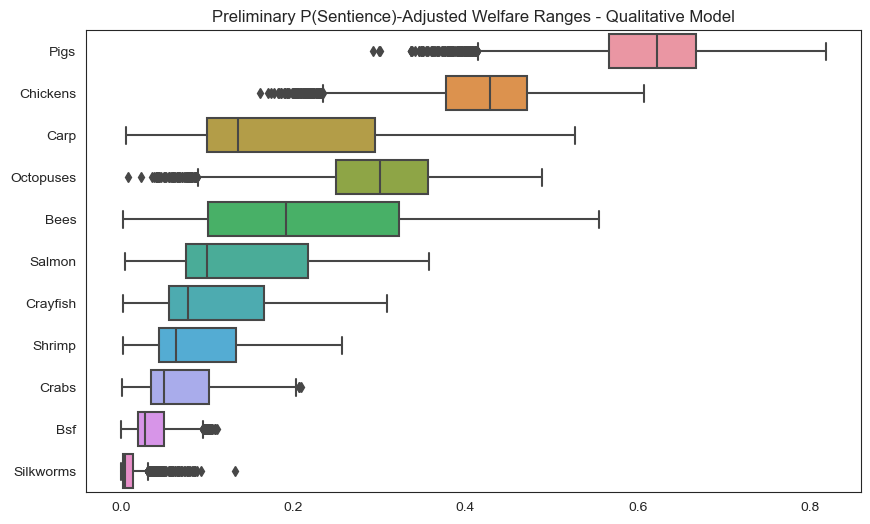

In [17]:
model = "Qualitative"
print(model)
print("P(Sentience) Adjusted Welfare Range:")
qual_df, qual_adj_wrs = all_species_adj_wr(model)
print(qual_df)
box_plot_adj_wr(model, qual_adj_wrs)

### High-Confidence Simple Scoring

High-Confidence (Simple Scoring)
P(Sentience) Adjusted Welfare Range:
           5th-pct  50th-pct  95th-pct
pigs         0.495     0.666     0.787
chickens     0.294     0.432     0.539
octopuses    0.170     0.316     0.447
bees         0.018     0.202     0.453
carp         0.034     0.146     0.417
salmon       0.025     0.107     0.300
crayfish     0.019     0.081     0.240
shrimp       0.015     0.067     0.193
crabs        0.012     0.052     0.151
bsf          0.008     0.029     0.082
silkworms    0.000     0.005     0.029


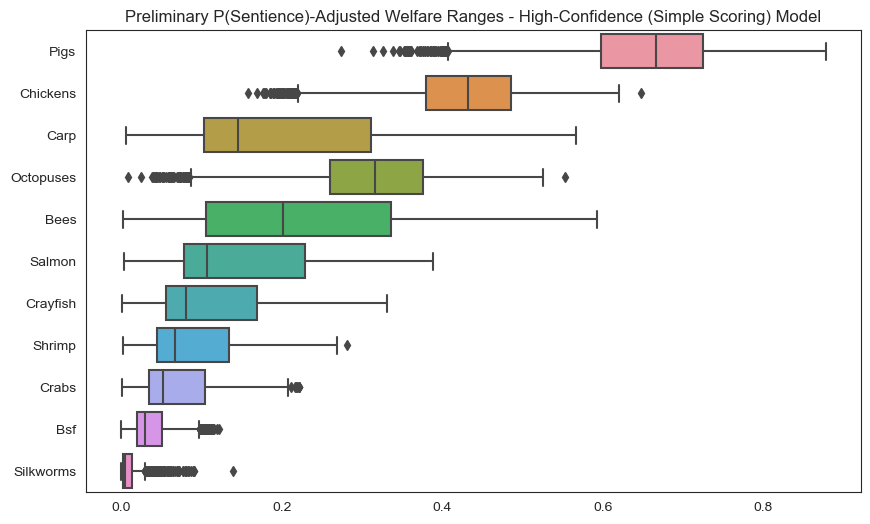

In [18]:
model = "High-Confidence (Simple Scoring)"
print(model)
print("P(Sentience) Adjusted Welfare Range:")
hc_ss_df, hc_ss_adj_wrs = all_species_adj_wr(model)
print(hc_ss_df)
box_plot_adj_wr(model, hc_ss_adj_wrs)


### Cubic

Cubic
P(Sentience) Adjusted Welfare Range:
           5th-pct  50th-pct  95th-pct
pigs         0.144     0.236     0.351
chickens     0.061     0.109     0.167
octopuses    0.022     0.051     0.091
bees         0.002     0.025     0.068
carp         0.004     0.021     0.068
salmon       0.002     0.009     0.027
crayfish     0.001     0.005     0.017
shrimp       0.000     0.002     0.008
crabs        0.000     0.002     0.007
bsf          0.000     0.000     0.002
silkworms    0.000     0.000     0.001


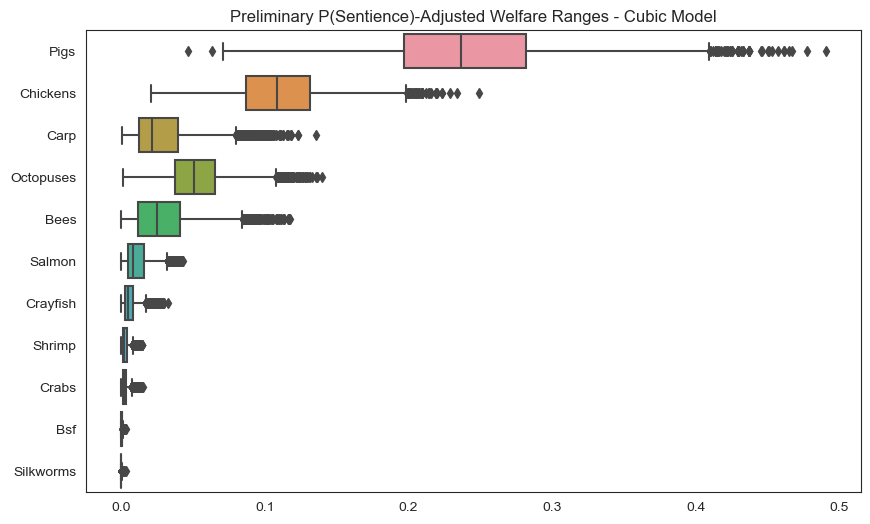

In [19]:
model = "Cubic"
print(model)
print("P(Sentience) Adjusted Welfare Range:")
cubic_df, cubic_adj_wrs = all_species_adj_wr(model)
print(cubic_df)
box_plot_adj_wr(model, cubic_adj_wrs)


### High-Confidence Cubic

High-Confidence (Cubic)
P(Sentience) Adjusted Welfare Range:
           5th-pct  50th-pct  95th-pct
pigs         0.162     0.286     0.434
chickens     0.058     0.113     0.190
octopuses    0.023     0.059     0.111
bees         0.002     0.028     0.083
carp         0.005     0.025     0.084
salmon       0.002     0.010     0.034
crayfish     0.001     0.005     0.020
shrimp       0.000     0.002     0.010
crabs        0.000     0.002     0.009
bsf          0.000     0.000     0.002
silkworms    0.000     0.000     0.001


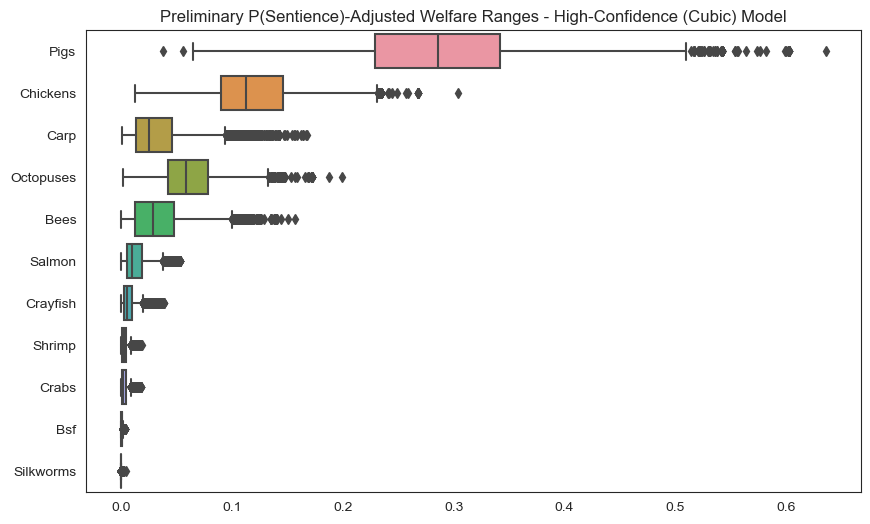

In [20]:
model = "High-Confidence (Cubic)"
print(model)
print("P(Sentience) Adjusted Welfare Range:")
hc_cubic_df, hc_cubic_adj_wrs = all_species_adj_wr(model)
print(hc_cubic_df)
box_plot_adj_wr(model, hc_cubic_adj_wrs)


### Qualitative Minus Social

Qualitative Minus Social
P(Sentience) Adjusted Welfare Range:
           5th-pct  50th-pct  95th-pct
pigs         0.477     0.630     0.745
chickens     0.293     0.429     0.528
octopuses    0.177     0.325     0.451
bees         0.018     0.196     0.437
carp         0.032     0.135     0.383
salmon       0.024     0.102     0.286
crayfish     0.019     0.078     0.229
shrimp       0.016     0.070     0.199
crabs        0.012     0.055     0.156
bsf          0.008     0.030     0.083
silkworms    0.000     0.005     0.031


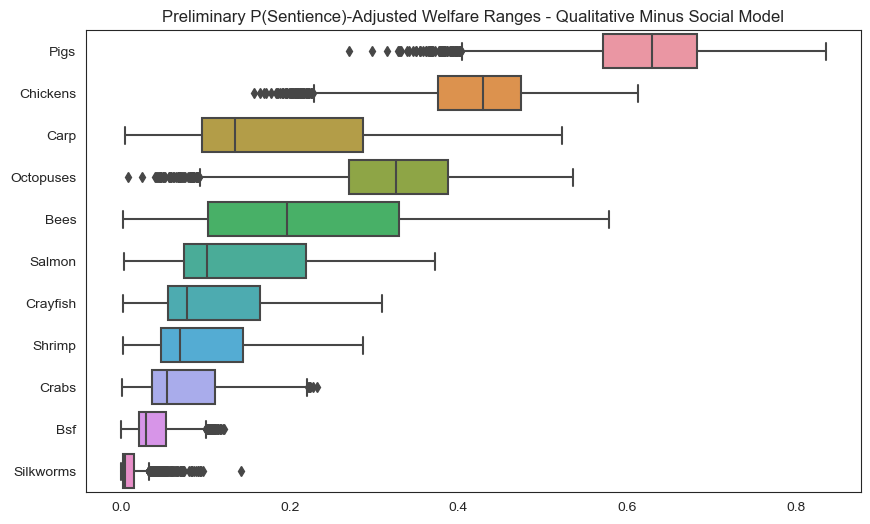

In [21]:
model = "Qualitative Minus Social"
print(model)
print("P(Sentience) Adjusted Welfare Range:")
qms_df, qms_adj_wrs = all_species_adj_wr(model)
print(qms_df)
box_plot_adj_wr(model, qms_adj_wrs)


### Pleasure-and-pain-centric

Pleasure-and-pain-centric
P(Sentience) Adjusted Welfare Range:
           5th-pct  50th-pct  95th-pct
pigs         0.456     0.627     0.754
octopuses    0.219     0.410     0.579
chickens     0.264     0.407     0.516
bees         0.016     0.187     0.436
carp         0.042     0.184     0.528
salmon       0.033     0.147     0.414
crayfish     0.025     0.109     0.320
shrimp       0.023     0.102     0.296
crabs        0.017     0.080     0.235
bsf          0.005     0.028     0.086
silkworms    0.000     0.006     0.038


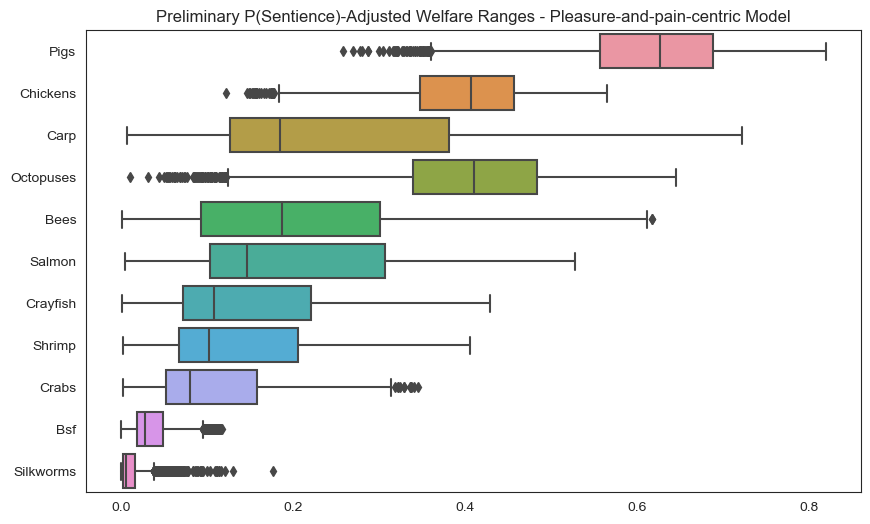

In [22]:
model = "Pleasure-and-pain-centric"
print(model)
print("P(Sentience) Adjusted Welfare Range:")
ppc_df, ppc_adj_wrs = all_species_adj_wr(model)
print(ppc_df)
box_plot_adj_wr(model, ppc_adj_wrs)


### Higher-lower Pleasures

Higher-Lower Pleasures
P(Sentience) Adjusted Welfare Range:
           5th-pct  50th-pct  95th-pct
pigs         0.228     0.355     0.494
chickens     0.113     0.190     0.275
octopuses    0.038     0.091     0.158
bees         0.005     0.054     0.138
carp         0.009     0.044     0.134
salmon       0.005     0.024     0.073
crayfish     0.002     0.010     0.035
shrimp       0.001     0.008     0.026
crabs        0.001     0.008     0.025
bsf          0.001     0.004     0.013
silkworms    0.000     0.001     0.004


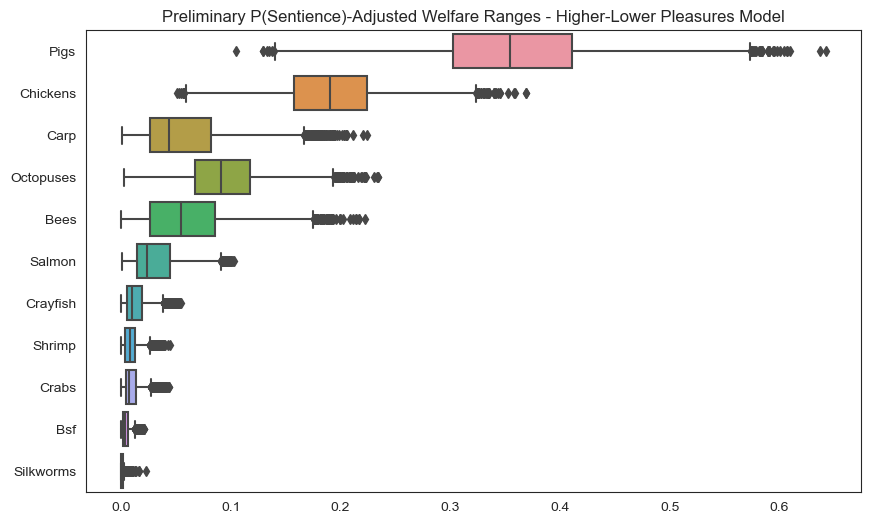

In [23]:
model = "Higher-Lower Pleasures"
print(model)
print("P(Sentience) Adjusted Welfare Range:")
hlp_df, hlp_adj_wrs = all_species_adj_wr(model)
print(hlp_df)
box_plot_adj_wr(model, hlp_adj_wrs)


### Undiluted Experience

Undiluted Experience
P(Sentience) Adjusted Welfare Range:
           5th-pct  50th-pct  95th-pct
octopuses    0.693     1.377     2.465
pigs         0.707     0.999     1.401
shrimp       0.167     0.844     3.137
chickens     0.532     0.826     1.185
carp         0.113     0.517     1.582
salmon       0.096     0.445     1.324
crayfish     0.095     0.443     1.420
crabs        0.077     0.373     1.241
bees         0.030     0.355     0.867
bsf          0.036     0.200     0.690
silkworms    0.002     0.052     0.388


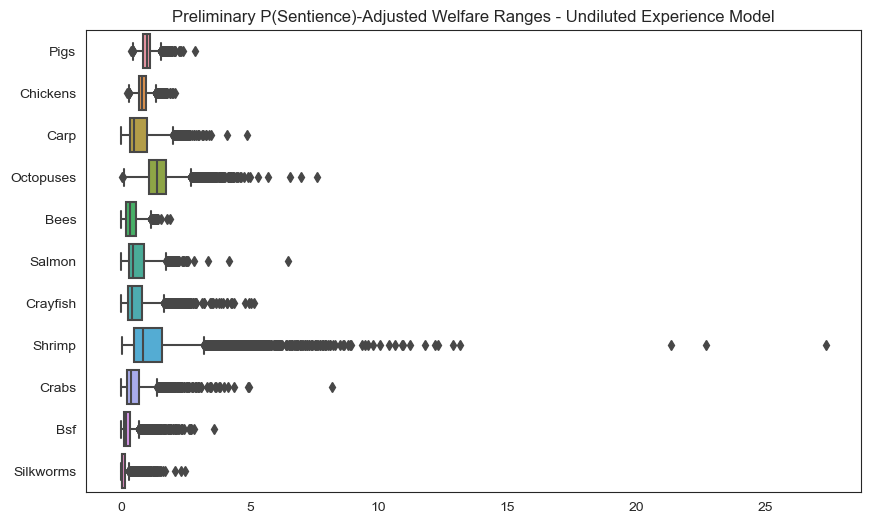

In [24]:
model = "Undiluted Experience"
print(model)
print("P(Sentience) Adjusted Welfare Range:")
ue_df, ue_adj_wrs = all_species_adj_wr(model)
print(ue_df)
box_plot_adj_wr(model, ue_adj_wrs)


### Mixture

Mixture
P(Sentience) Adjusted Welfare Range:
           5th-pct  50th-pct  95th-pct
pigs         0.201     0.572     1.076
chickens     0.086     0.371     0.872
octopuses    0.036     0.268     1.542
carp         0.009     0.110     0.663
bees         0.006     0.097     0.475
salmon       0.004     0.077     0.558
crayfish     0.002     0.059     0.524
shrimp       0.001     0.047     1.181
crabs        0.001     0.039     0.489
bsf          0.000     0.018     0.230
silkworms    0.000     0.003     0.081


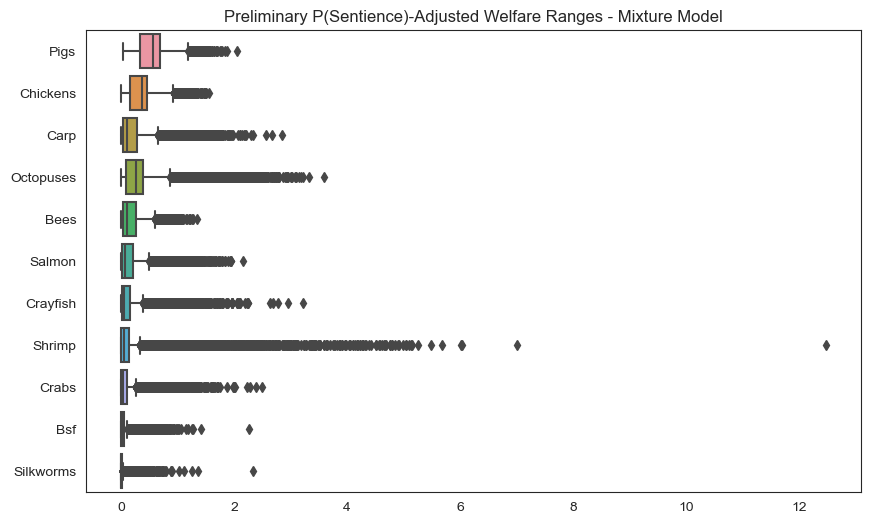

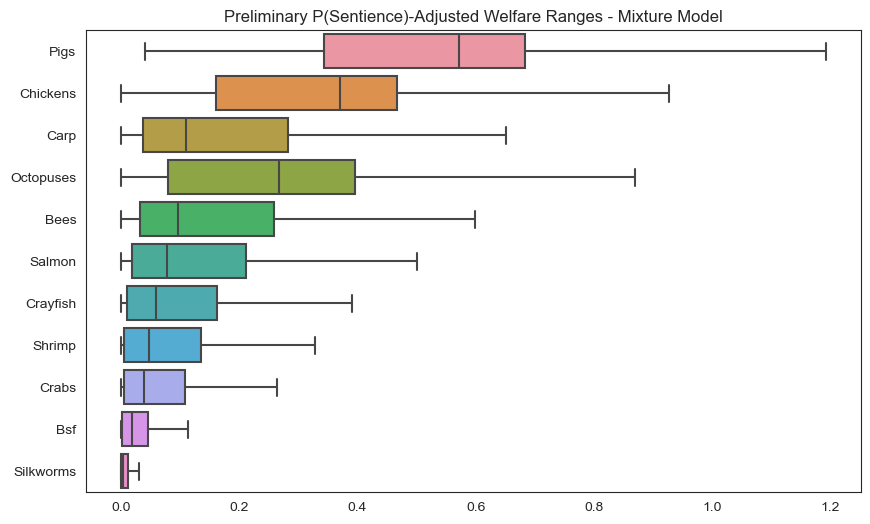

In [25]:
model = "Mixture"
print(model)
print("P(Sentience) Adjusted Welfare Range:")
mix_df, mix_adj_wrs = all_species_adj_wr(model)
print(mix_df)
box_plot_adj_wr(model, mix_adj_wrs)

box_plot_adj_wr(model, mix_adj_wrs, showfliers=False)

def get_quartiles(mix_adj_wrs):
    percentiles = {}
    for i, species in enumerate(SPECIES2):
        percentiles[species] = {'25th': 0, '75th': 0}
        percentiles[species]['25th'] = np.percentile(mix_adj_wrs[i], 25)
        percentiles[species]['75th'] = np.percentile(mix_adj_wrs[i], 75)
    return percentiles


## Mixture With Neuron Count Model

Mixture Neuron Count
P(Sentience) Adjusted Welfare Range:
           5th-pct  50th-pct  95th-pct
pigs         0.005     0.518     1.042
chickens     0.002     0.319     0.846
octopuses    0.004     0.236     1.520
carp         0.000     0.091     0.610
bees         0.000     0.070     0.451
salmon       0.000     0.056     0.518
crayfish     0.000     0.037     0.524
shrimp       0.000     0.030     1.031
crabs        0.000     0.024     0.474
bsf          0.000     0.012     0.190
silkworms    0.000     0.001     0.062


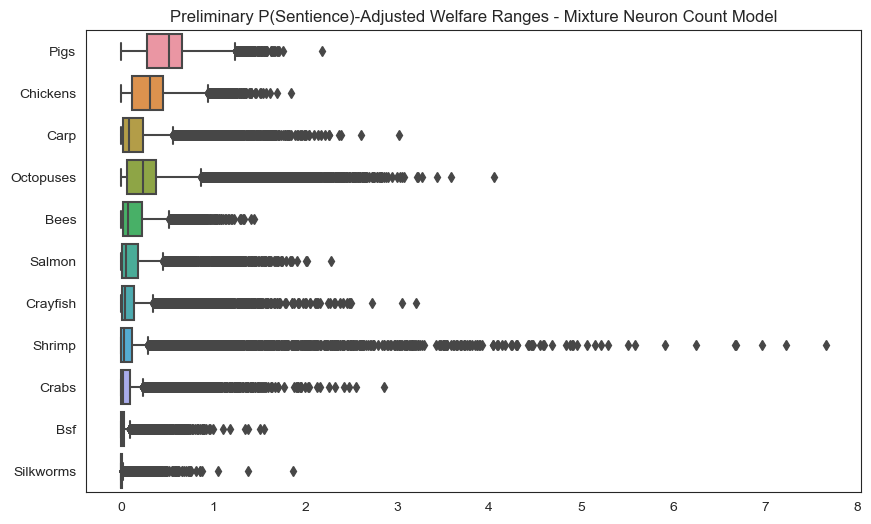

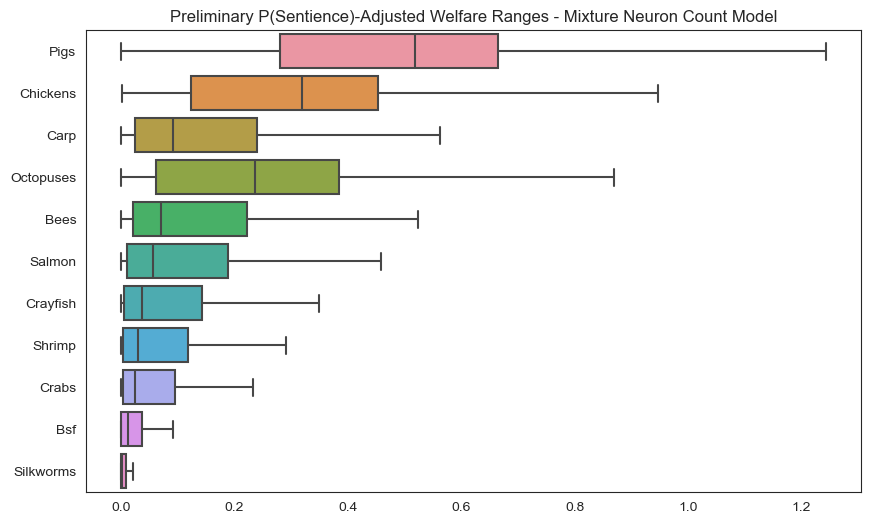

In [26]:
model = "Mixture Neuron Count"
print(model)
print("P(Sentience) Adjusted Welfare Range:")
mix_df, mix_adj_wrs = all_species_adj_wr(model)
print(mix_df)
box_plot_adj_wr(model, mix_adj_wrs)

box_plot_adj_wr(model, mix_adj_wrs, showfliers=False)

def get_quartiles(mix_adj_wrs):
    percentiles = {}
    for i, species in enumerate(SPECIES2):
        percentiles[species] = {'25th': 0, '75th': 0}
        percentiles[species]['25th'] = np.percentile(mix_adj_wrs[i], 25)
        percentiles[species]['75th'] = np.percentile(mix_adj_wrs[i], 75)
    return percentiles

## Tests


In [27]:
import unittest
simple_models = {'Qualitative': {"Proxies": qual_proxies, "Function": qual_f}, 
                'High-Confidence (Simple Scoring)': {"Proxies": hc_proxies, "Function": qual_f}, 
                'Cubic': {"Proxies": cubic_proxies, "Function": cubic_f}, 
                'High-Confidence (Cubic)': {"Proxies": hc_proxies, "Function": cubic_f}, 
                'Qualitative Minus Social': {"Proxies": qms_proxies, "Function": qms_f}, 
                'Pleasure-and-pain-centric': {"Proxies": ppc_proxies, "Function": ppc_f}}

proxies = {'qualitative': {'List': qual_proxies_list, 'Set': qual_proxies}, 
            'cubic': {'List': cubic_proxies_list, 'Set': cubic_proxies}, 
            'qualitative minus social': {"List": qms_proxies_list, 'Set': qms_proxies},
            'pleasure-and-pain-centric': {"List": ppc_proxies_list, 'Set': ppc_proxies}, 
            'higher/lower pleasures - cognitive': {'List': hlp_cog_proxies_list, 'Set': hlp_cog_proxies},
            'higher-lower pleasures - hedonic': {'List': hlp_hed_proxies_list, 'Set': hlp_hed_proxies},
            'undiluted experience - cognitive': {'List': ue_cog_proxies_list, 'Set': ue_cog_proxies},
            'undiluted experience - hedonic': {'List': ue_hed_proxies_list, 'Set': ue_hed_proxies}}

complex_models = {'Higher-Lower Pleasures': {"Hedonic Proxies": hlp_hed_proxies, "Cognitive Proxies": hlp_cog_proxies, "Function": hlp_f}, 
                'Undiluted Experience': {"Hedonic Proxies": ue_hed_proxies, "Cognitive Proxies": ue_cog_proxies, "Function": ue_f}}

class TestSimpleFunctions(unittest.TestCase):

    def test_proxies(self):
        pass_test = True
        for model in proxies:
            if set(proxies[model]['List']) != proxies[model]['Set']:
                pass_test = False
        self.assertTrue(pass_test)

    def test_filter_proxies(self):
        pass_test = True
        for model in simple_models:
            model_proxies = simple_models[model]["Proxies"]
            for animal in data.keys():
                animal_scores = data[animal]["Scores"]
                if set(filter_proxies(animal_scores, model_proxies).keys()) != model_proxies:
                    pass_test = False
        self.assertTrue(pass_test)    

    def test_one_sim_wr(self):
        pass_test = True
        for x in [0, 1]:
            test_scores = {}
            for proxy in cubic_proxies:
                if proxy in hc_proxies:
                    test_scores[proxy] = [x*HC_WEIGHT]*NUM_SCENARIOS
                else:
                    test_scores[proxy] = [x]*NUM_SCENARIOS
            for model in simple_models:
                model_proxies = simple_models[model]['Proxies']
                filtered_scores = filter_proxies(test_scores, model_proxies)

                human_sum = get_human_sum(model, model_proxies, hc_proxies)
                f = simple_models[model]['Function']
                prediction = f(x)
                for i in range(NUM_SCENARIOS):
                    p = one_sim_welfare_range(model, f, filtered_scores, i, 60, human_sum)
                    if p != prediction:
                        pass_test = False
                        print("Model: {}".format(model))
                        print("X: {}".format(x))
                        print("prediction: {}".format(prediction))
                        print("p: {}".format(p))
        self.assertTrue(pass_test)

def one_species_welfare_ranges_2(f, species_scores, cog_proxies, hed_proxies, hc_proxies, fff):
    cognitive_scores = filter_proxies(species_scores, cog_proxies)
    hedonic_scores = filter_proxies(species_scores, hed_proxies)
    human_sum_cog = get_human_sum_2(cog_proxies, hc_proxies)
    human_sum_hed = get_human_sum_2(hed_proxies, hc_proxies)
  
    welfare_range_list = []
    for i in range(NUM_SCENARIOS):
        welfare_range_i = one_sim_welfare_range_2(f, cognitive_scores, hedonic_scores, human_sum_cog, human_sum_hed, i, fff)
        welfare_range_list.append(welfare_range_i)
    
    return welfare_range_list
    
class TestComplexFuctions(unittest.TestCase):
    def test_one_sim_relative_score(self):
        pass_test = True
        for x in [0,1]:
            test_scores = {}
            for proxy in cubic_proxies:
                if proxy in hc_proxies:
                    test_scores[proxy] = [x*HC_WEIGHT]*NUM_SCENARIOS
                else:
                    test_scores[proxy] = [x]*NUM_SCENARIOS
            for model in complex_models:
                for term in {"Hedonic Proxies", "Cognitive Proxies"}:
                    model_proxies = complex_models[model][term]
                    filtered_proxies = filter_proxies(test_scores, model_proxies)
                    human_sum = get_human_sum_2(model_proxies, hc_proxies)
                    prediction = x
                    for i in range(NUM_SCENARIOS):
                        p = one_sim_relative_score(filtered_proxies, i, human_sum)
                        if p != prediction:
                            pass_test = False
                            print("Model: {}".format(model))
                            print("X: {}".format(x))
                            print("Term: {}".format(term))
                            print("Prediction: {}".format(prediction))
                            print("Actual: {}".format(p))
        self.assertTrue(pass_test)

    def test_one_sim_welare_range_2(self):
        pass_test = True
        for i, x in enumerate([(0.1, 1), (1, 0.1)]): 
            hed_test_scores = {}
            cog_test_scores = {}
            for proxy in cubic_proxies:
                if proxy in hc_proxies:
                    cog_test_scores[proxy] = [x[0]*HC_WEIGHT]*NUM_SCENARIOS
                    hed_test_scores[proxy] = [x[1]*HC_WEIGHT]*NUM_SCENARIOS
                else:
                    cog_test_scores[proxy] = [x[0]]*NUM_SCENARIOS
                    hed_test_scores[proxy] = [x[1]]*NUM_SCENARIOS

            for model in complex_models:
                human_sum_cog = get_human_sum_2(complex_models[model]["Cognitive Proxies"], hc_proxies)
                human_sum_hed = get_human_sum_2(complex_models[model]["Hedonic Proxies"], hc_proxies)

                cog_model_proxies = complex_models[model]["Cognitive Proxies"]
                cog_proxies = filter_proxies(cog_test_scores, cog_model_proxies)
               
                hed_model_proxies = complex_models[model]["Hedonic Proxies"]
                hed_proxies = filter_proxies(hed_test_scores, hed_model_proxies)
                
                cog_rel_score = one_sim_relative_score(cog_proxies, 0, human_sum_cog)
                hed_rel_score = one_sim_relative_score(hed_proxies, 0, human_sum_hed)

                f = complex_models[model]["Function"]
                prediction = f(cog_rel_score, hed_rel_score)

                for i in range(NUM_SCENARIOS):
                    p = one_sim_welfare_range_2(f, cog_proxies, hed_proxies, human_sum_cog, human_sum_hed, i, 60)
                
                    if p != prediction:
                        pass_test = False
                        print("Model: {}".format(model))
                        print("X: {}".format(x))
                        print("Prediction: {}".format(prediction))
                        print("Actual: {}".format(p))
        self.assertTrue(pass_test)

    def test_one_species_wr_2(self):
        pass_test = True
        for x in {1}: 
            test_scores = {}
            for proxy in cubic_proxies:
                if proxy in hc_proxies:
                    test_scores[proxy] = [x*HC_WEIGHT]*NUM_SCENARIOS
                else:
                    test_scores[proxy] = [x]*NUM_SCENARIOS

        for model in complex_models:
            f = complex_models[model]["Function"]
            cog_proxies = complex_models[model]["Cognitive Proxies"]
            hed_proxies = complex_models[model]["Hedonic Proxies"]
            wr_list = one_species_welfare_ranges_2(f, test_scores, cog_proxies, hed_proxies, hc_proxies, 60)
            expect = [1]*NUM_SCENARIOS
            if wr_list != expect:
                pass_test = False
                print("Model: ", model)
                print("Expected: ", expect[0:10])
                print("Actual: ", wr_list[0:10])
        self.assertTrue(pass_test)

class TestMultiplication(unittest.TestCase):
    models = ['Qualitative', 'High-Confidence (Simple Scoring)', \
                'Cubic', 'High-Confidence (Cubic)', \
                'Qualitative Minus Social', 'Pleasure-and-pain-centric', \
                'Higher-Lower Pleasures', 'Undiluted Experience', "Mixture"]
    def test_check_multiplication(self):
        pass_test = True
        
        for model in models: 
            
            for species in SPECIES2:
                if species != 'shrimp':
                    with open(os.path.join('sentience_estimates', '{}_psent_hv1_model.p'.format(species)), 'rb') as f_s:
                        species_psent = list(pickle.load(f_s))
                else:
                    with open(os.path.join('sentience_estimates', 'shrimp_assumed_psent.p'), 'rb') as f_s:
                        species_psent = list(pickle.load(f_s))
                with open(os.path.join('welfare_range_estimates', '{}_wr_{}_model.p'.format(species, model)), 'rb') as f_wr:
                    species_wr = list(pickle.load(f_wr)) 
                exp_adj_wrs = []
                for i in range(NUM_SCENARIOS):
                    adj_wr = max(species_psent[i]*species_wr[i],0)
                    exp_adj_wrs.append(adj_wr)
                adj_wr = one_species_adj_wr(species, model)
                if exp_adj_wrs != adj_wr:
                    pass_test = False
        self.assertTrue(pass_test)


res2 = unittest.main(argv=[''], verbosity=3, exit=False)

test_one_sim_relative_score (__main__.TestComplexFuctions) ... ok
test_one_sim_welare_range_2 (__main__.TestComplexFuctions) ... ok
test_one_species_wr_2 (__main__.TestComplexFuctions) ... ok
test_check_multiplication (__main__.TestMultiplication) ... ok
test_filter_proxies (__main__.TestSimpleFunctions) ... ok
test_one_sim_wr (__main__.TestSimpleFunctions) ... ok
test_proxies (__main__.TestSimpleFunctions) ... ok

----------------------------------------------------------------------
Ran 7 tests in 2.203s

OK
